In [87]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
/home/kien/Crystal-Plasticity-COE
Moving up to the parent directory
/home/kien


In [88]:
yieldingPoint = 0.004

def getIndexBeforeStrainLevel(strain, level):
    for i in range(len(strain)):
        if strain[i] > level:
            return i - 1
def preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ):
    strainPathXprocess = strainPathX.copy()
    strainPathYprocess = strainPathY.copy()
    strainPathZprocess = strainPathZ.copy()
    turningIndices = turningStressPoints(trueStress)
    #print(turningIndices)
    #unloadingIndex = turningIndices[0]
    reloadingIndex = turningIndices[1]
    for i in range(reloadingIndex, trueStrain.size):
        strainPathXprocess[i] -= strainPathX[reloadingIndex]
        strainPathYprocess[i] -= strainPathY[reloadingIndex]
        strainPathZprocess[i] -= strainPathZ[reloadingIndex]
    strainReloading = (2/3 * (strainPathXprocess ** 2 + strainPathYprocess ** 2 + strainPathZprocess ** 2)) ** (1/2) + trueStrain[reloadingIndex]
    actualStrain = trueStrain.copy()
    for i in range(reloadingIndex, trueStrain.size):
        actualStrain[i] = strainReloading[i]
    return (actualStrain, trueStress)

def turningStressPoints(trueStress):
    differences = np.diff(trueStress)
    index = 1
    turningIndices = []
    while index < differences.size:
        if (differences[index - 1] <= 0 and differences[index] >= 0) or (differences[index - 1] >= 0 and differences[index] <= 0):
            turningIndices.append(index)
        index += 1
    return turningIndices

def preprocessDAMASKNonlinear(path):
    df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    strainPathX = df["1_ln(V)"].to_numpy().reshape(-1)
    strainPathY = df["5_ln(V)"].to_numpy().reshape(-1)
    strainPathZ = df["9_ln(V)"].to_numpy().reshape(-1)
    return preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ)

################################
# Preprocessing linear loading #
################################

def preprocessLinear(trueStrain, trueStress):
    # truePlasticStrain = trueStrain - trueElasticstrain = trueStrain - trueStress/Young's modulus
    Young = (trueStress[1] - trueStress[0]) / (trueStrain[1] - trueStrain[0])
    truePlasticStrain = trueStrain - trueStress / Young    
    return (truePlasticStrain, trueStress)

def preprocessDAMASKLinear(path):
    df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    return preprocessLinear(trueStrain, trueStress)   

##############################
# Obtain the original curves #
##############################

def preprocessDAMASKTrue(path):
    df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    trueStrain = df["Mises(ln(V))"]
    trueStress = df["Mises(Cauchy)"] 
    return (trueStrain, trueStress)



## Parameter analysis in the PH model

### Note: no need to multiply stress by 1e-6

/tmp/ipykernel_285/647726715.py:43: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/647726715.py:43: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/647726715.py:43: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old

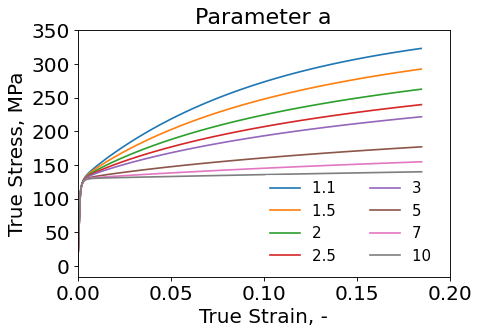

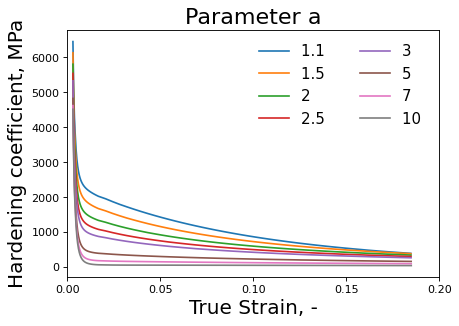

In [4]:
paramValues = ["1.1","1.5","2","2.5","3","5","7","10"] # <- put the postprocessed files here and rename to the param's value change. Remmeber to keep the exponent
#paramValues_a = ["1.1","3","10"]
paramName = "a" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "a" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 4.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) -5
    plasticStrain = trueStrain[beforeYieldingIndex:]
    plasticStress = trueStress[beforeYieldingIndex:]
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}") #marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=True, fontsize=size - 4.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/165661826.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/165661826.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/165661826.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old

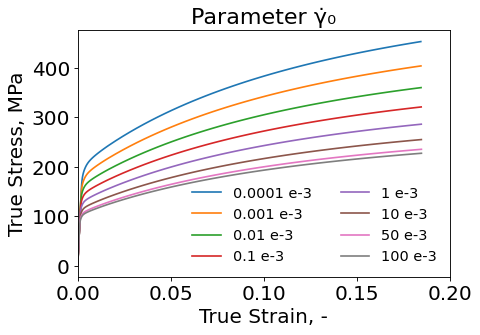

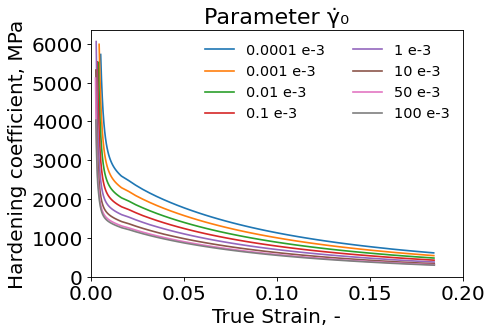

In [276]:
paramValues = ["0.0001","0.001","0.01","0.1","1","10","50","100"]
#paramValues_gdot0 = ["0.0001","0.1","100"]
paramName = "gdot0" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "γ̇₀" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "e-3" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,100,200,300,400]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [23,21, 20, 18, 15, 14, 13,14]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}") #marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=True, fontsize=size - 5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)



/tmp/ipykernel_285/3027264162.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3027264162.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3027264162.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

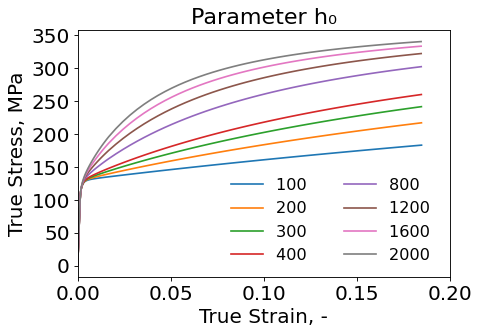

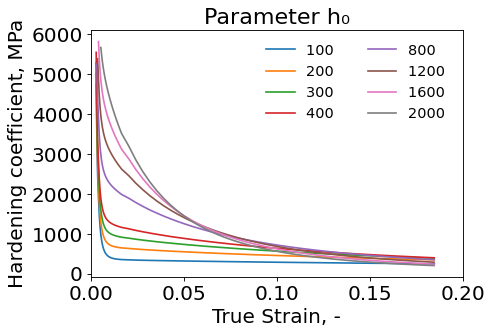

In [152]:
paramValues = ["100","200","300","400","800","1200","1600","2000"]
paramName = "h0" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "h₀" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,15, 15, 15, 17, 19, 20,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/2104064486.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2104064486.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2104064486.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

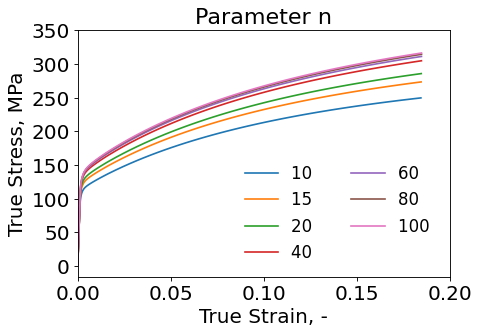

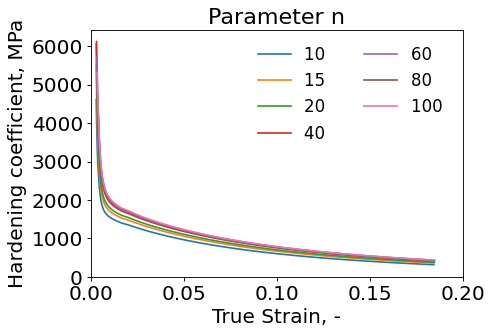

In [281]:
paramValues = ["10","15","20","40","60","80","100"]
paramName = "n" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "n" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [15,15, 15, 16, 17, 19, 18,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)



/tmp/ipykernel_285/1664528770.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1664528770.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1664528770.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

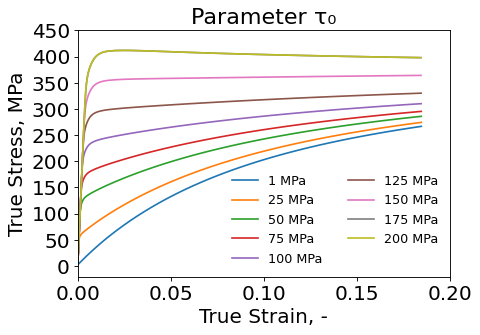

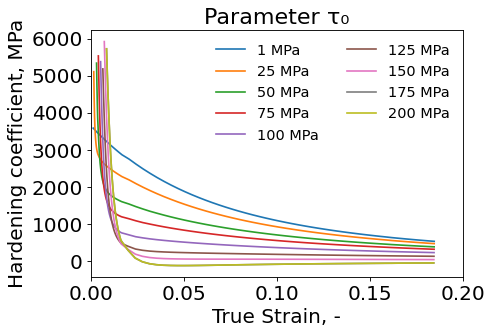

In [302]:
paramValues = ["1","25","50","75","100","125","150","175","200"]
paramName = "tau0" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "τ₀" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "MPa" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350,400,450]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 6.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [6,8, 16, 20, 23, 26, 28,31,31]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)


    


/tmp/ipykernel_285/2453283813.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2453283813.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2453283813.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

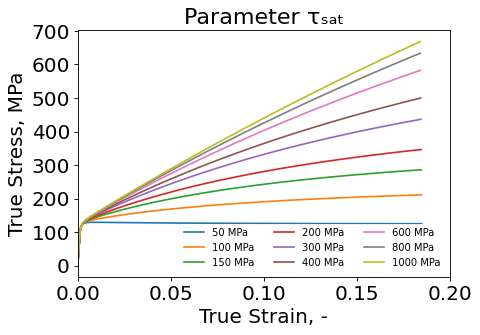

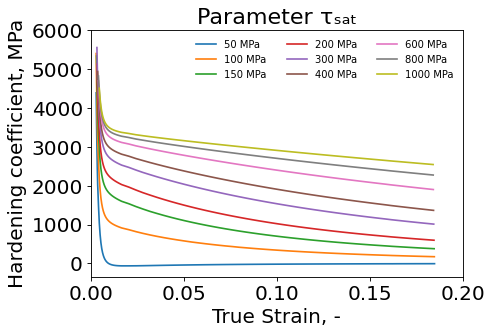

In [153]:
paramValues = ["50","100","150","200","300","400","600","800","1000"]
paramName = "tausat" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "τₛₐₜ" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "MPa" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,100,200,300,400,500,600,700]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 9, ncol=3, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,15, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 9, ncol=3, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/2201803225.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2201803225.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2201803225.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

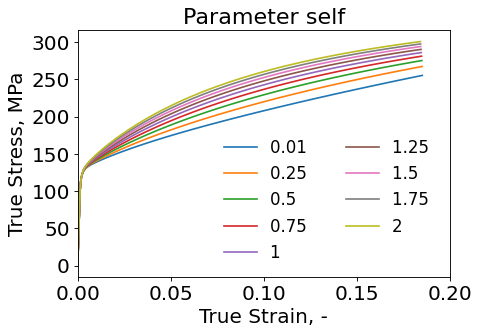

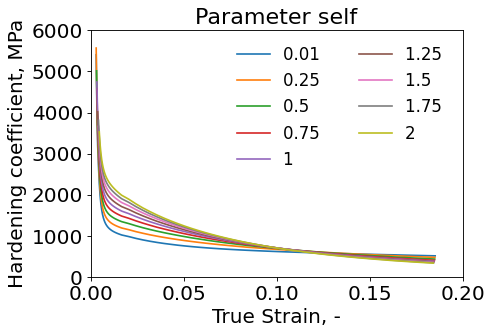

In [311]:
paramValues = ["0.01","0.25","0.5","0.75","1","1.25","1.5","1.75","2"]
paramName = "self" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "self" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,15, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/2711387575.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2711387575.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2711387575.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

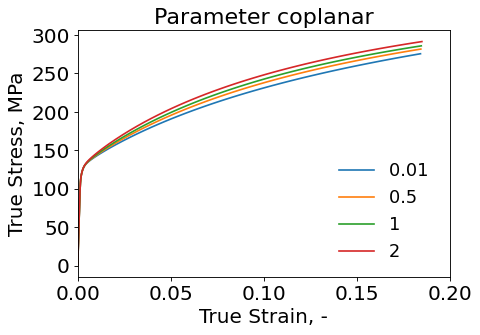

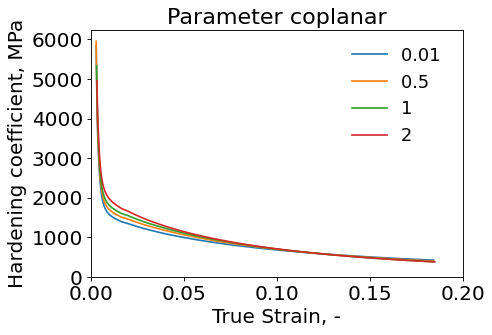

In [310]:
paramValues = ["0.01","0.5","1","2"]
paramName = "coplanar" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "coplanar" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [15,15, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/4094479115.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/4094479115.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/4094479115.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

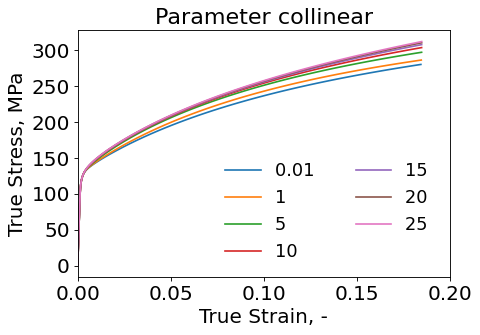

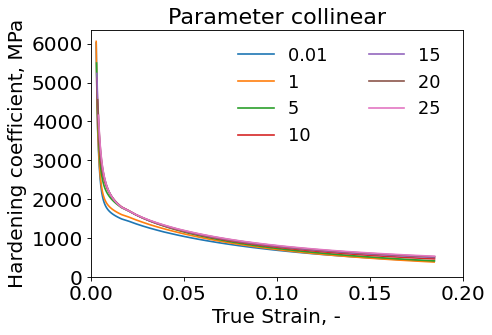

In [172]:
paramValues = ["0.01","1","5","10","15","20","25"]
paramName = "collinear" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "collinear" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [15,15, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/3846676946.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3846676946.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3846676946.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

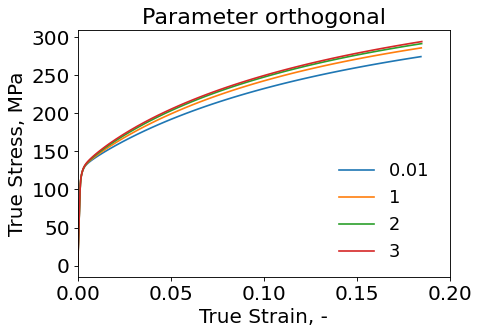

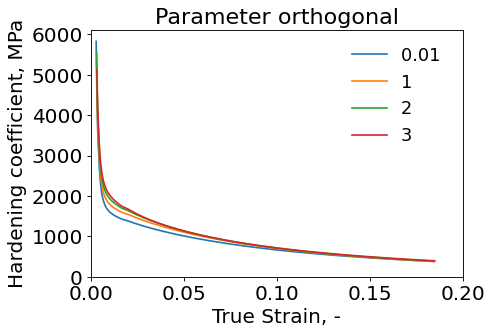

In [179]:
paramValues= ["0.01","1","2","3"]
paramName = "orthogonal" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "orthogonal" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,16, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/3015522334.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3015522334.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3015522334.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

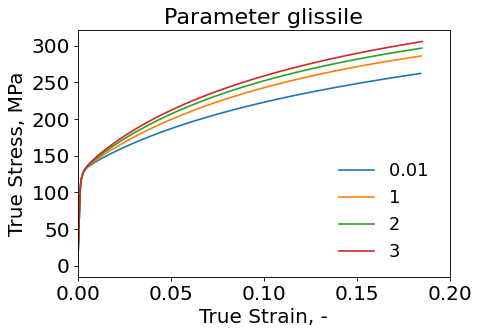

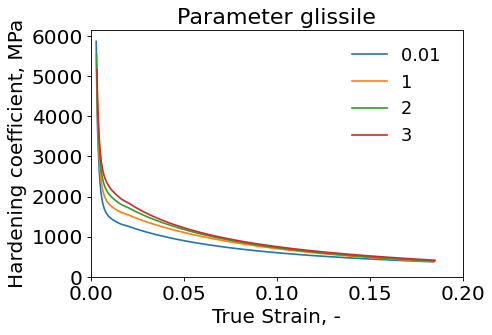

In [178]:
paramValues = ["0.01","1","2","3"]
paramName = "glissile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "glissile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,16, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/2932654651.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2932654651.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2932654651.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

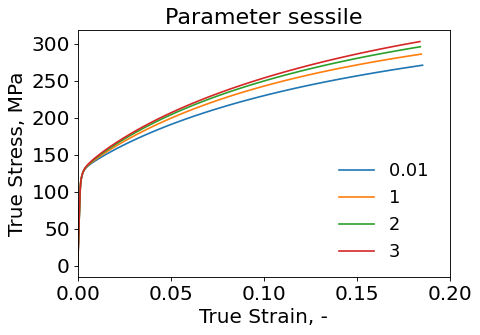

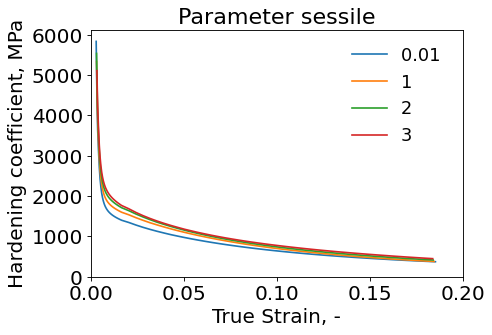

In [177]:
paramValues = ["0.01","1","2","3"]
paramName = "sessile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "sessile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,16, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

## Parameter analysis in the DB model

### Note: need to multiply stress by 1e-6

/tmp/ipykernel_285/472012000.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/472012000.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/472012000.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old

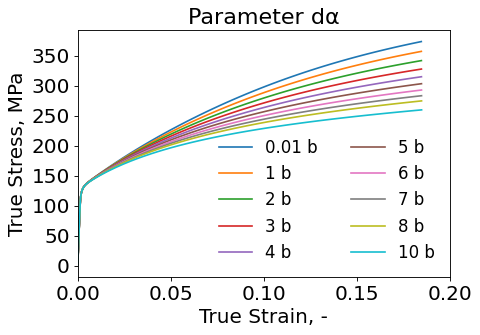

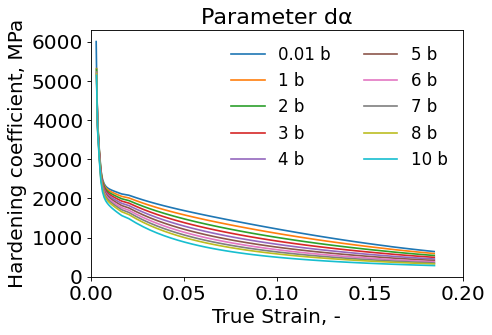

In [187]:
paramValues = ["0.01","1","2","3","4","5","6","7","8","10"] # <- put the postprocessed files here and rename to the param's value change
paramName = "dipole"
paramNameLatex = "dα"
paramUnit = "b"
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [15,16, 16, 17, 17, 17, 16,16,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/1233752435.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1233752435.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1233752435.py:45: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

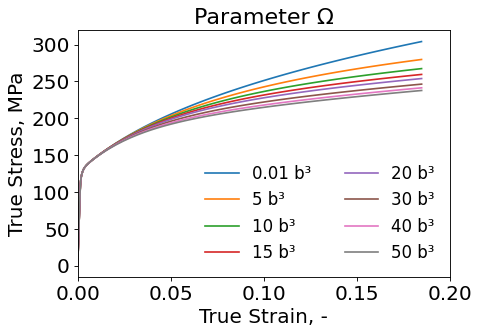

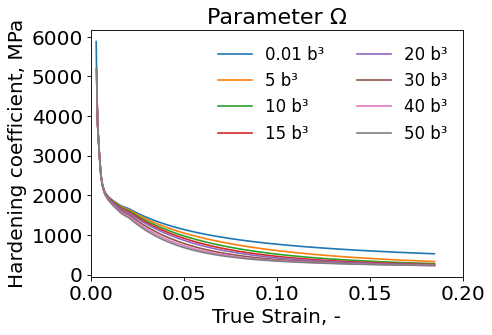

In [188]:
paramValues = ["0.01","5","10","15","20","30","40","50"] # <- put the postprocessed files here and rename to the param's value change
paramName = "omega"
paramNameLatex = "Ω"
paramUnit = "b³"
size = 18

############################### 
# dipole
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,16, 16, 17, 17, 17, 16,16,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/110625383.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/110625383.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/110625383.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old

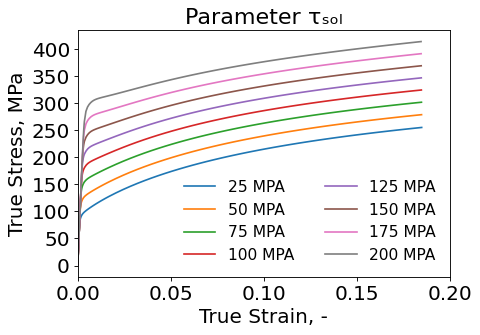

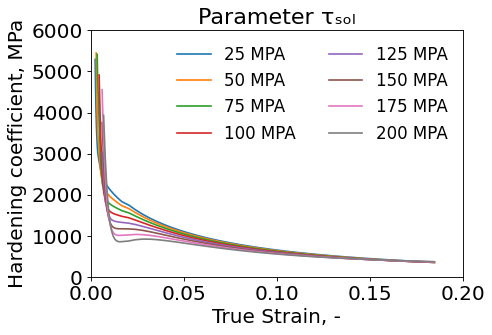

In [207]:
paramValues = ["25","50","75","100","125","150","175","200"] # <- put the postprocessed files here and rename to the param's value change
paramName = "tausol"
paramNameLatex = "τₛₒₗ"
paramUnit = "MPA"
size = 18

############################### 
# dipole
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350,400]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [12,15, 18, 20, 22, 22, 22,23,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/922859556.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/922859556.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/922859556.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old

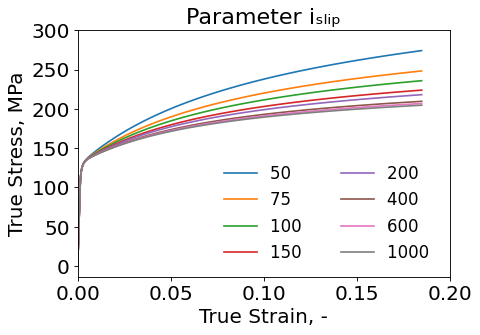

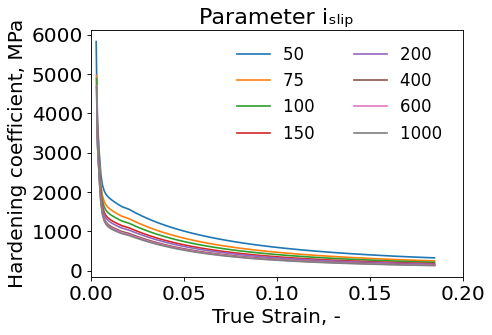

In [208]:
paramValues = ["50","75","100","150","200","400","600","1000"]
paramName = "islip"
paramNameLatex = "iₛₗᵢₚ"
paramUnit = ""
size = 18

# Adding 
############################### 
# Qc
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,16, 16, 17, 17, 17, 16,16,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/2506085673.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2506085673.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2506085673.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

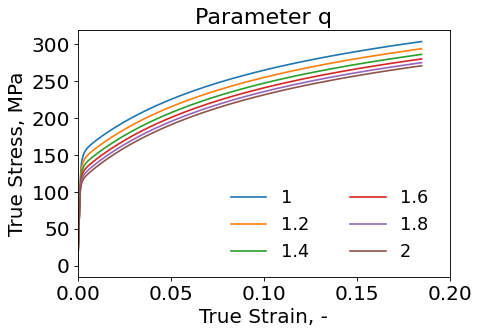

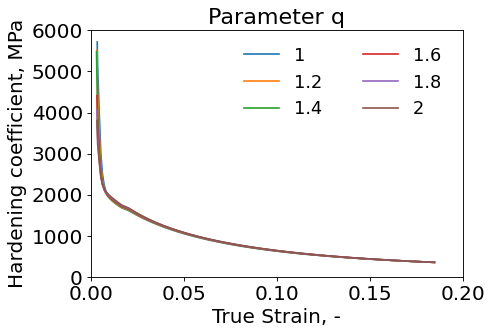

In [303]:
paramValues = ["1","1.2","1.4","1.6","1.8","2"]
paramName = "q"
paramNameLatex = "q"
paramUnit = ""
size = 18

# Adding 
############################### 
# Qc
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [18,17, 16, 17, 17, 17, 16,16,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/1742233672.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1742233672.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1742233672.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

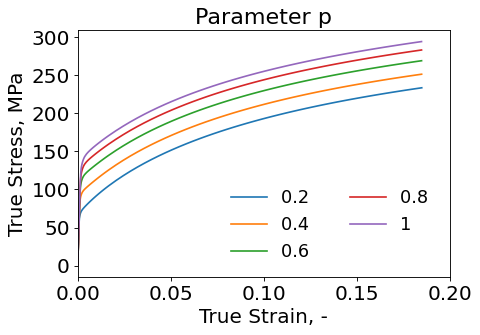

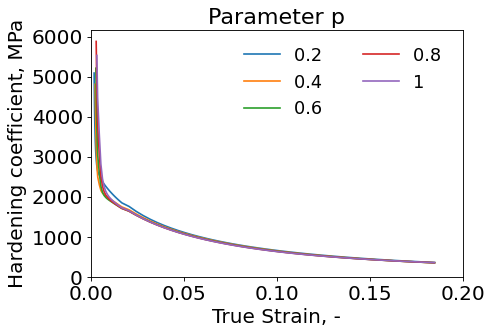

In [304]:
paramValues = ["0.2","0.4","0.6","0.8","1"]
paramName = "p"
paramNameLatex = "p"
paramUnit = ""
size = 18

# Adding 
############################### 
# Qc
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [9,12, 14, 15, 17, 17, 15,16,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/135348392.py:47: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/135348392.py:47: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/135348392.py:47: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old

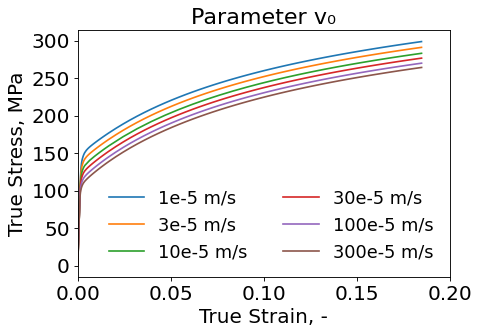

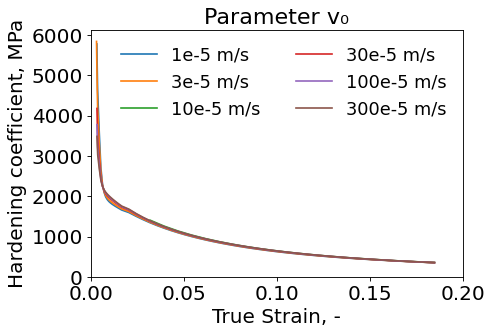

In [305]:
# paramValues_v0 = ["1e-5", "3e-5", "5e-5", "10e-5","15e-5"]
# paramValues_v0 = ["15e-5", "30e-5", "100e-5", "300e-5"]
paramValues = ["1e-5", "3e-5", "10e-5", "30e-5", "100e-5", "300e-5"]
paramName = "v0"
paramNameLatex = "v₀"
paramUnit = "m/s"
size = 18

############################### 
# v0
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [17,16, 16, 17, 17, 17, 16,16,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/347100801.py:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/347100801.py:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/347100801.py:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old

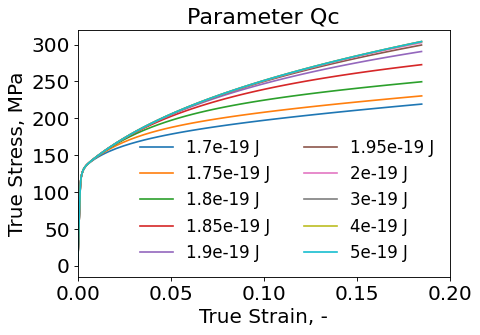

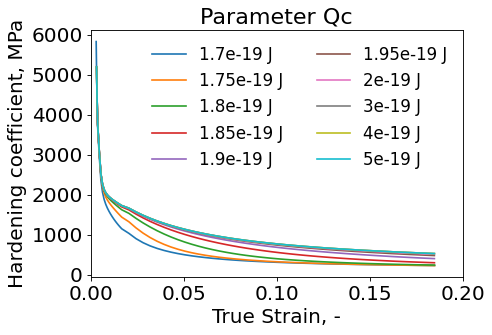

In [227]:
# paramValues_Qc = ["1.7e-19", "1.75e-19", "1.8e-19", "1.85e-19", "2e-19"]
# paramValues_Qc = ["2e-19", "3e-19", "4e-19", "5e-19"]
# paramValues_Qc = ["1.7e-19", "1.725e-19", "1.75e-19", "1.775e-19", "1.8e-19", "1.825e-19", "1.85e-19",  "1.875e-19", "1.9e-19", "1.925e-19", "1.95e-19", "1.975e-19", "2e-19", "3e-19", "4e-19", "5e-19"]
paramValues = ["1.7e-19","1.75e-19", "1.8e-19","1.85e-19", "1.9e-19", "1.95e-19", "2e-19", "3e-19", "4e-19", "5e-19"]
paramName = "Qc"
paramNameLatex = "Qc"
paramUnit = "J"
size = 18

# Adding 
############################### 
# Qc
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,16, 16, 17, 17, 17, 16,16,16,16,16]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/2328466548.py:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2328466548.py:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2328466548.py:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

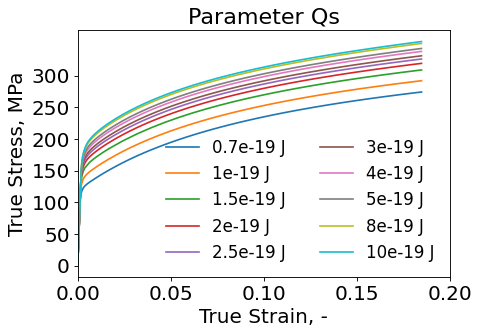

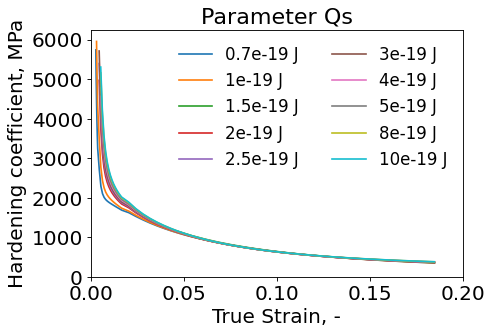

In [234]:
#paramValues_Qs = ["0.7e-19", "0.8e-19", "1e-19", "1.25e-19", "1.5e-19"]
#paramValues_Qs = ["1.5e-19", "2e-19", "3e-19", "4e-19", "5e-19", "10e-19"]
#paramValues_Qs = ["1e-19", "1.5e-19", "2e-19", "2.5e-19", "3e-19", "8e-19", "9e-19", "10e-19"]
paramValues = ["0.7e-19","1e-19","1.5e-19" , "2e-19" , "2.5e-19","3e-19","4e-19", "5e-19", "8e-19", "10e-19"]
paramName= "Qs"
paramNameLatex = "Qs"
paramUnit = "J"
size = 18
# 1, 1.5, 2, 2.5, 3 # 8, 9, 10
# paramValues_Qs = ["0.7e-19", "0.8e-19", "0.9e-19", "1e-19", "2e-19", "3e-19", "8e-19", "9e-19", "10e-19"]
############################### 
# Qs
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [14,16, 18, 20, 20, 20, 21,21,21,21,25]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


/tmp/ipykernel_285/3351522950.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3351522950.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/3351522950.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

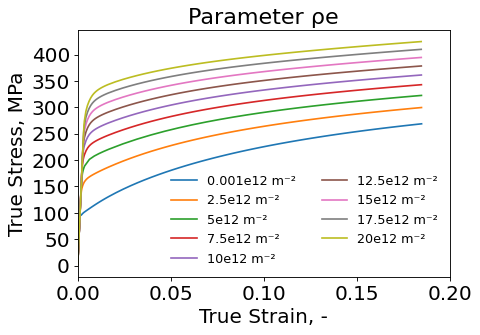

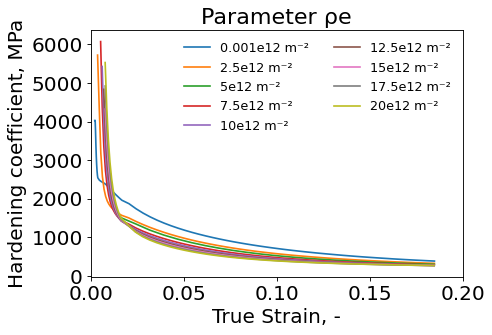

In [307]:
paramValues = ["0.001e12", "2.5e12", "5e12", "7.5e12", "10e12", "12.5e12", "15e12", "17.5e12", "20e12"]
#paramValues_rho_e = ["0.1e12", "1e12", "2.5e12", "5e12", "7.5e12", "10e12", "12.5e12", "15e12", "17.5e12", "20e12"]
paramName = "rho_e"
paramNameLatex = "ρe"
paramUnit = "m⁻²"
size = 18

############################### 
# rho_e
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350,400]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 6.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index =  [11,19, 11, 21, 22, 23, 24,24,24,25,26]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 6.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

/tmp/ipykernel_285/1715597968.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1715597968.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/1715597968.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

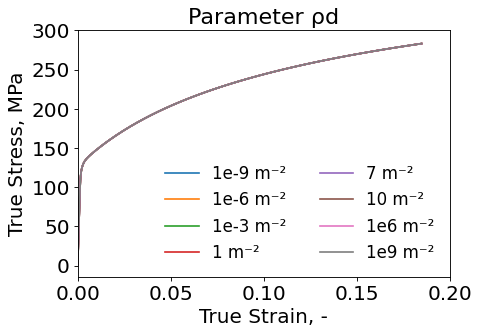

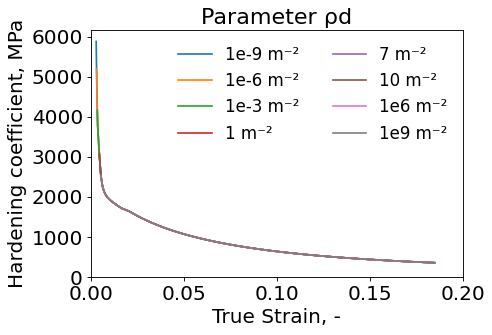

In [248]:
#paramValues_rho_d = ["1e-9", "2e-9", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "1e9", "2e9"]
paramValues = ["1e-9","1e-6","1e-3","1","7","10","1e6","1e9"]
paramName = "rho_d"
paramNameLatex = "ρd"
paramUnit = "m⁻²"
size = 18

############################### 
# rho_d
###############################

figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [15,16, 18, 20, 20, 20, 21,21,21,21,25]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)



/tmp/ipykernel_285/2249983967.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2249983967.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2249983967.py:46: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

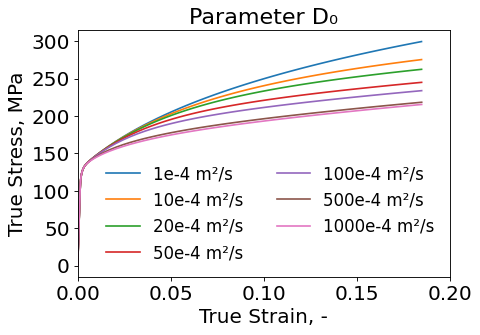

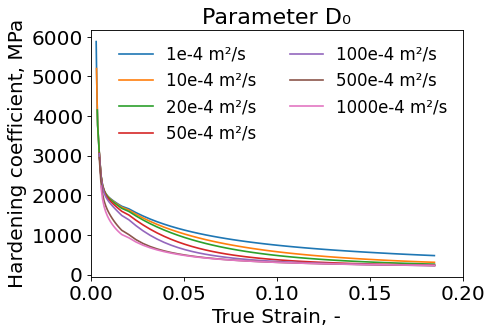

In [308]:
paramValues = ["1e-4", "10e-4","20e-4","50e-4", "100e-4","500e-4","1000e-4"]
paramName = "D0"
paramNameLatex = "D₀"
paramUnit = "m²/s"
size = 18

# Adding 
############################### 
# Qc
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

counter = 0
index = [15,16, 18, 20, 20, 20, 21,21,21,21,25]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 3, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


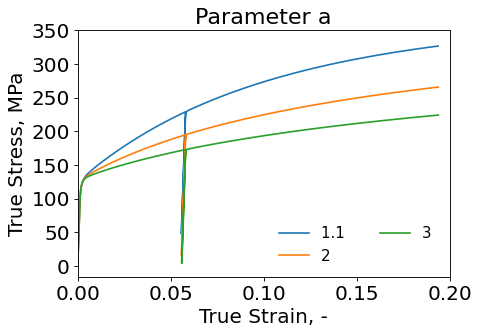

In [55]:
paramValues_a = ["1.1","2","3"] # <- put the postprocessed files here and rename to the param's value change. Remmeber to keep the exponent
#paramValues_a = ["1.1","3","10"]
paramName = "a" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "a" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues_a: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 4.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


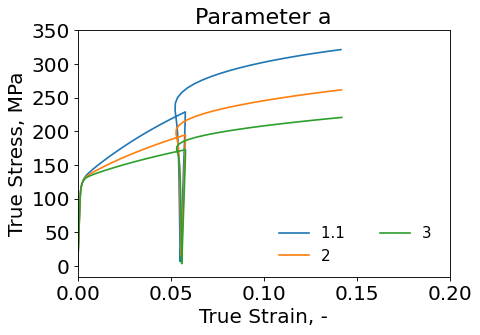

In [251]:
paramValues_a = ["1.1","2","3"] # <- put the postprocessed files here and rename to the param's value change. Remmeber to keep the exponent
#paramValues_a = ["1.1","3","10"]
paramName = "a" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "a" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues_a: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300,350]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 4.5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

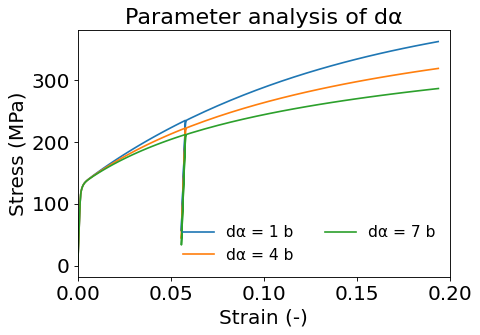

In [65]:
paramValues = ["1","4","7"] # <- put the postprocessed files here and rename to the param's value change
paramName = "dipole"
paramNameLatex = "dα"
paramUnit = "b"
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
#plt.ylim([80, 710])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)



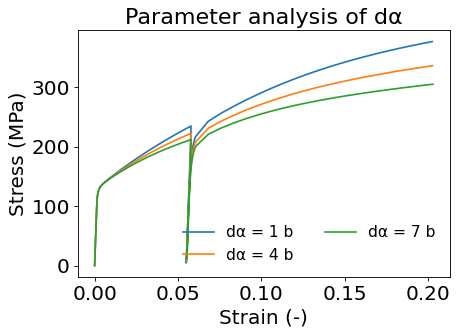

In [66]:
paramValues = ["1","4","7"] # <- put the postprocessed files here and rename to the param's value change
paramName = "dipole"
paramNameLatex = "dα"
paramUnit = "b"
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKNonlinear(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
#plt.ylim([80, 710])
#plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)



/tmp/ipykernel_285/2852313446.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2852313446.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plasticStrain = plasticStrain[1:]
/tmp/ipykernel_285/2852313446.py:44: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the 

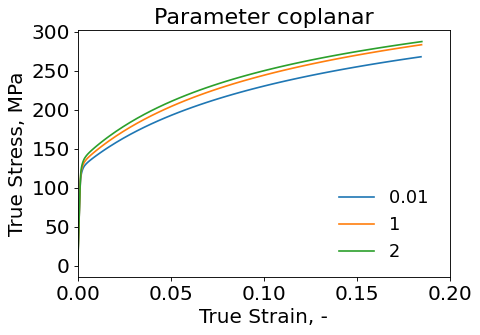

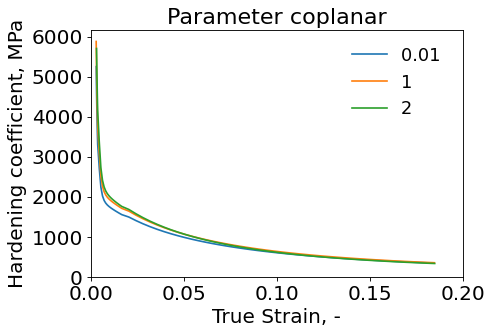

In [309]:
paramValues = ["0.01","1","2"]
paramName = "coplanar" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "coplanar" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex}", size=size + 2)
#plt.title(f"Step 2: Control hardening", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.yticks([0,50,100,150,200,250,300]) 
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=True, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
counter = 0
index = [15,15, 16, 17, 17, 19, 20,20,21,22,23]
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6
    #beforeYieldingIndex = getIndexBeforeStrainLevel(trueStrain, yieldingPoint) 
    plasticStrain = trueStrain[index[counter]:]
    plasticStress = trueStress[index[counter]:]
    counter += 1
    
    hardening_coefficient = np.diff(plasticStress)/np.diff(plasticStrain)
    plasticStrain = plasticStrain[1:]
    plt.plot(plasticStrain, hardening_coefficient, label = f"{paramValue} {paramUnit}")#marker='.', markersize=5)
    plt.title(f"Parameter {paramNameLatex}", size=size + 2)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.yticks([0,1000,2000,3000,4000,5000,6000])  
plt.xlim([0, 0.2])
plt.ylabel('Hardening coefficient, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=1, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)